# Clean the local midi files directory
Clean the directory of midi files and group them by format

In [1]:
import os
import numpy as np
from music21 import *
import pretty_midi
import mido
import re

In [3]:
def clean_midi_directory(path):
    for file in os.listdir(path):
        if file == '.DS_Store':
            continue
        index = 1
        for midi in os.listdir(path + file):
            if midi == '.DS_Store':
                continue
            new_midi = file+'_'+str(index)+'.mid'
            old_path = path + file + '/' + midi
            new_path = path + file + '/' + new_midi
            os.rename(old_path,new_path)
            index += 1

In [4]:
path1 = 'classical_midi_format1/'
path2 = 'classical_midi_format0/'
clean_midi_directory(path1)
clean_midi_directory(path2)

# Explore midi files

2 formats of midi files:  
format 0:  all tracks are merged into a single track  
format 1: seperate information for each track  

**I'm using format 0 for this project**

Format 1 - contain multiple tracks

music21 having trouble parsing midi files with multiple tracks - try pretty_midi instead

In [5]:
file = os.listdir('classical_midi_all_format1')[0]
file_path = 'classical_midi_all_format1/' + file
midi_pretty_format = pretty_midi.PrettyMIDI(file_path)
print(file)

chopin_29.mid


In [6]:
midi_pretty_format.instruments

[Instrument(program=0, is_drum=False, name="Piano right"),
 Instrument(program=0, is_drum=False, name="Piano left")]

Format 0 - contain one track

In [7]:
file = os.listdir('classical_midi_all_format0')[0]
file_path = 'classical_midi_all_format0/' + file
midi_pretty_format = pretty_midi.PrettyMIDI(file_path)
print(file)

chopin_29.mid


Get piano channel

In [8]:
piano_midi = midi_pretty_format.instruments[0]
piano_midi

Instrument(program=0, is_drum=False, name="Chopin Ballade in G minor Opus 32")

Get duration of song

In [32]:
piano_midi.get_end_time()/60

8.991384968229191

Get notes  

Start: the start of a note played in second.   
End: the end of a note played in a second. There can be a overlap multi notes in a time.  
Pitch: the MIDI number of the Note played.  
Velocity: the force which the note is played. 

In [9]:
piano_midi.notes[0:5]

[Note(start=0.001811, end=2.172967, pitch=36, velocity=74),
 Note(start=0.001811, end=2.172967, pitch=48, velocity=90),
 Note(start=2.172967, end=2.580909, pitch=39, velocity=66),
 Note(start=2.172967, end=2.580909, pitch=51, velocity=79),
 Note(start=2.580909, end=2.970519, pitch=44, velocity=70)]

Get piano roll  

In [10]:
piano_roll = piano_midi.get_piano_roll()

shape=(128,times) - The notes length is 128 and time is the duration of the music divided by FPS.

In [11]:
piano_roll.shape

(128, 53948)

Convert the piano roll to a dictionary key, value = time, notes  
Then convert the notes into strings

In [12]:
# this dictionary starts from the time where the note is played

time_notes_dict = {}

times = np.unique(np.where(piano_roll > 0)[1])
index = np.where(piano_roll > 0) # contains index of matching rows and cols

for time in times:
    index_where = np.where(index[1] == time)
    notes = index[0][index_where]
    time_notes_dict[time] = notes


In [14]:
for time, notes in time_notes_dict.items():
    if len(notes) == 1:
        time_notes_dict[time] = str(notes[0])
    else:
        notes = [str(note) for note in notes]
        time_notes_dict[time] = ','.join(notes)

In [15]:
time_notes_dict

{83: '45,57,73,76,81',
 84: '45,57,73,76,81',
 85: '45,57,73,76,81',
 86: '45,57,73,76,81',
 87: '45,57,73,76,81',
 88: '45,57,73,76,81',
 89: '45,57,73,76,81',
 90: '45,57,73,76,81',
 91: '45,57,73,76,81',
 92: '45,57,73,76,81',
 93: '45,57,73,76,81',
 94: '45,57,73,76,81',
 95: '45,57,73,76,81',
 96: '45,57,73,76,81',
 97: '45,57,73,76,81',
 98: '45,57,73,76,81',
 99: '45,57,73,76,81',
 100: '45,57,73,76,81',
 101: '45,57,73,76,81',
 102: '45,57,73,76,81',
 103: '45,57,73,76,81',
 104: '45,57,73,76,81',
 105: '45,57,73,76,81',
 106: '45,57,73,76,81',
 107: '45,49,57,61,73,76,81',
 108: '45,49,57,61,73,76,81',
 109: '45,49,57,61,73,76,81',
 110: '45,49,57,61,73,76,81',
 111: '45,49,57,61,73,76,81',
 112: '45,49,57,61,73,76,81',
 113: '45,49,57,61,73,76,81',
 114: '45,49,57,61,73,76,81',
 115: '45,49,57,61,73,76,81',
 116: '45,49,57,61,73,76,81',
 117: '45,49,57,61,73,76,81',
 118: '45,49,57,61,73,76,81',
 119: '45,49,57,61,73,76,81',
 120: '45,49,57,61,73,76,81',
 121: '45,49,57,61,73

Next: get input and target for neural networks

# Write functions for preprocessing midi files

## Get piano rolls from midi files

In [35]:
classical_midi = 'classical_midi_all_format0/'
midi_list = []
for midi in os.listdir(classical_midi):
    if midi == '.DS_Store':
        continue
    midi_list.append(classical_midi+midi)

In [12]:
len(midi_list)

316

In [13]:
def get_piano_roll_dict(midi_list):
    
    """
    Generate a dictionary of piano rolls
    
    Parameters
    ==========
    midi_list: list of paths of midi files
    
    """
    
    piano_roll_dict = {}
    for i in range(len(midi_list)):
        midi = midi_list[i]
        midi_pretty_format = pretty_midi.PrettyMIDI(midi)
        piano_midi = midi_pretty_format.instruments[0]
        piano_roll = piano_midi.get_piano_roll()
        piano_roll_dict[i] = piano_roll
    return piano_roll_dict

In [130]:
piano_roll_dict = get_piano_roll_dict(midi_list = midi_list)

In [131]:
piano_roll_dict

{0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 1: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 2: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 3: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

## Convert piano rolls to dictionarys of (time,notes)

In [14]:
def piano_roll_to_dict(piano_roll):
    """
    Generate a dictionary of (time,notes) for one song
    """
    time_notes_dict = {}

    times = np.unique(np.where(piano_roll > 0)[1])
    index = np.where(piano_roll > 0) 

    for time in times:
        index_where = np.where(index[1] == time)
        notes = index[0][index_where]
        time_notes_dict[time] = notes
    
    for time, notes in time_notes_dict.items():
        if len(notes) == 1:
            time_notes_dict[time] = str(notes[0])
        else:
            notes = [str(note) for note in notes]
            time_notes_dict[time] = ','.join(notes)
    return time_notes_dict

In [15]:
def get_time_notes_dict(piano_roll_dict):
    """
    Generate a list of dictionaries of (time,notes)
    
    Parameters
    ==========
    piano_roll_dict: A dictionary of piano rolls 
    
    """
    time_notes_dict_list = []
    for i in piano_roll_dict:
        time_notes_dict = piano_roll_to_dict(piano_roll_dict[i])
        time_notes_dict_list.append(time_notes_dict)
    return time_notes_dict_list

In [79]:
time_notes_dict_list = get_time_notes_dict(piano_roll_dict)

## Get input and target for neural networks

Using sliding windows of length 50 to predict the notes in the next timestamp.

In [16]:
def generate_input_and_target(time_notes_dict, seq_len=50):
    """ 
    Generate input and the target of our neural networks for one song.
    
    Parameters
    ==========
    time_notes_dict : Dictionary of timestep and notes
    seq_len : The length of the sequence
      
    Returns
    =======
    Tuple of list of input and list of target of neural network.

    
    """
    # get the start and end timestamps
    start, end = sorted(time_notes_dict.keys())[0], sorted(time_notes_dict.keys())[-1]
    list_training, list_target = [], []
    
    # each loop gives us one window and one target
    for index, time in enumerate(range(start, end)):
        list_append_training, list_append_target = [], []
        start_iterate = 0
        flag_target_append = False
        
        # for the first 50 timestamps, add 'e' to the seq list before first note in the window. 
        if index < seq_len:
            start_iterate = seq_len - index - 1
            for i in range(start_iterate):
                list_append_training.append('e')
                flag_target_append = True

        for i in range(start_iterate,seq_len):
            index = time - (seq_len - i - 1)
            if index in time_notes_dict:
                list_append_training.append(time_notes_dict[index])
                pass
            else:
                list_append_training.append('e')

        # get the target at time+1
        if time+1 in time_notes_dict:
            list_append_target.append(time_notes_dict[time+1])
        else:
            list_append_target.append('e')
        list_training.append(list_append_training)
        list_target.append(list_append_target)
    return list_training, list_target

In [109]:
list_training, list_target = generate_input_and_target(time_notes_dict_list[0], seq_len=50)

## Assign indices to notes

In [17]:
def get_notes_index_dict(time_notes_dict):
    """
    Assign indices to notes and generate a dictionary with indices and notes
    """
    notes_index_dict = {}
    notes_index_dict['e'] = 0
    index = 1
    for time, notes in time_notes_dict.items():
        if notes not in notes_index_dict:
            notes_index_dict[notes] = index
            index += 1
        else:
            pass
    return notes_index_dict

In [107]:
notes_index_dict = get_notes_index_dict(time_notes_dict_list[0])

In [119]:
len(notes_index_dict)

85

In [18]:
def notes_to_index(list_training, list_target, notes_index_dict):
    """
    Convert notes to corresponding indices.
    """
    index_training = []
    index_target = []
    for wind_train, note_target in zip(list_training, list_target): 
        index_target.append(notes_index_dict[note_target[0]])
        lst_train_wind = []
        for note_train in wind_train:
            lst_train_wind.append(notes_index_dict[note_train])
        index_training.append(lst_train_wind)
    return index_training, index_target

In [111]:
index_training, index_target = notes_to_index(list_training, list_target, notes_index_dict)

In [117]:
len(index_training) == len(list_training)

True

In [118]:
len(index_target) == len(list_target)

True

# Preprocessing all midi files

In [22]:
midi_file_list = []
for midi in os.listdir(classical_midi):
    if midi == '.DS_Store':
        continue
    midi_file_list.append(midi)

In [25]:
midi_composor_list = []
for midi in os.listdir(classical_midi):
    if midi == '.DS_Store':
        continue
    composor = re.match('(.*)_', midi).group(1)
    midi_composor_list.append(composor)

In [27]:
piano_roll_dict = get_piano_roll_dict(midi_list = midi_list)

In [28]:
time_notes_dict_list = get_time_notes_dict(piano_roll_dict)

In [29]:
# this takes a while to run; save it in pickle

import pickle
with open('pickle/time_notes_dict_list.pickle', 'wb') as to_write:
    pickle.dump(time_notes_dict_list,to_write)

In [30]:
len(time_notes_dict_list)

316

In [31]:
# modify get_notes_index_dict so the dictionary collects notes and indices from all the songs

def get_notes_index_dict2(time_notes_dict, notes_index_dict, index):
    for time, notes in time_notes_dict.items():
        if notes not in notes_index_dict:
            notes_index_dict[notes] = index
            index += 1
        else:
            pass
    return index, notes_index_dict

Get the notes-index dict for notes from all midi files

In [32]:
notes_index_dict = {}
notes_index_dict['e'] = 0
index = 1
for time_notes_dict in time_notes_dict_list:
    index, notes_index_dict = get_notes_index_dict2(time_notes_dict, notes_index_dict, index)

In [33]:
# number of unique notes

len(notes_index_dict)

116017

In [34]:
with open('pickle/notes_index_dict.pickle', 'wb') as to_write:
    pickle.dump(notes_index_dict,to_write)

Create a list of dictionaries. Each dictionary contains the information of one song.

In [35]:
all_song = []

for i in range(316):
    song_dict = {}
    midi_file_name = midi_file_list[i]
    song_dict['file_name'] = midi_file_name
    composer = midi_composor_list[i]
    song_dict['composer'] = composer
    time_notes_dict = time_notes_dict_list[i]
    song_dict['time_notes_dict'] = time_notes_dict
    list_training, list_target = generate_input_and_target(time_notes_dict_list[0], seq_len=50)
    index_training, index_target = notes_to_index(list_training, list_target, notes_index_dict)
    song_dict['train'] = index_training
    song_dict['target'] = index_target
    all_song.append(song_dict)

In [36]:
len(all_song)

316

In [37]:
with open('pickle/all_song.pickle', 'wb') as to_write:
    pickle.dump(all_song,to_write)

# Some visualizations

## Piano roll of one song

Text(0.5, 1.0, "The Piano Roll Representation of Chopin's Ballade G minor")

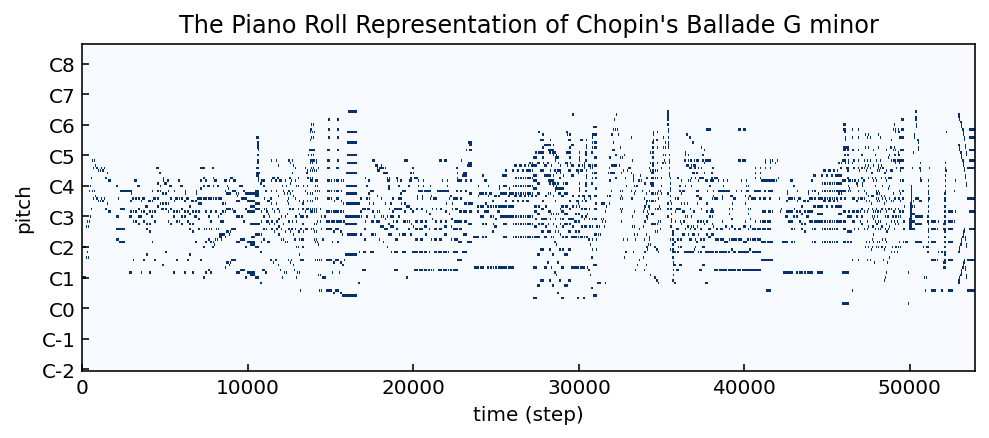

In [70]:
import pypianoroll
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,3)) 
pypianoroll.plot_pianoroll(ax,piano_roll.T,preset = 'default', grid = 'off')
plt.title("The Piano Roll Representation of Chopin's Ballade G minor" )

## Duration of songs

In [39]:
def get_song_duration(midi_list):

    duration_list = []

    for i in range(len(midi_list)):
        midi = midi_list[i]
        midi_pretty_format = pretty_midi.PrettyMIDI(midi)
        midi_duration = midi_pretty_format.get_end_time()/60
        duration_list.append(midi_duration)
    return duration_list

In [60]:
import pandas as pd
durations = pd.Series(get_song_duration(midi_list), name = 'Duration(mins)')

In [71]:
sum(durations)/len(durations)

4.057866155569177

In [61]:
est_duration = durations.round()

Text(0.5, 1.0, 'Duration of Songs')

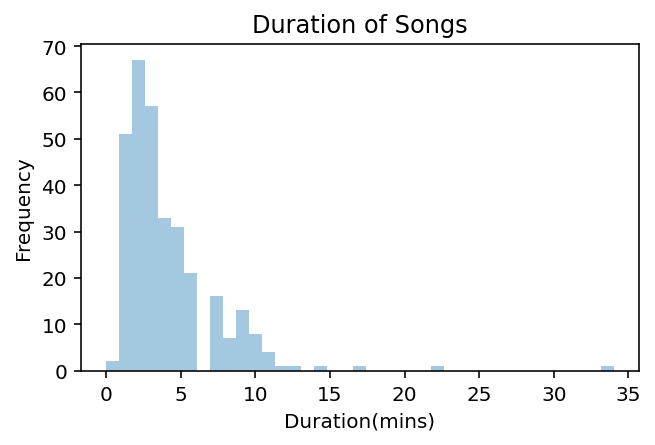

In [68]:
import seaborn as sns

plt.figure(figsize=(5,3))
sns.distplot(est_duration, kde=False)
plt.ylabel('Frequency') 
plt.title('Duration of Songs')